<a href="https://colab.research.google.com/github/plopezmp/AmI/blob/main/AmI_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Las figuras de las secciones *Objetivo de entrenamiento*, *Gaussian RBF kernel*, y *Regresión con SVM* están obtenidas del libro:

* A. Géron. *Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems*. O’Reilly Media, 2019.

**Preambulo:**

Montamos nuestro `Google Drive` donde tenemos guardado el notebook de Python.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')
%pwd

'/content/drive/My Drive/Colab Notebooks'

---

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# seaborn plotting por defecto
import seaborn as sns; sns.set()
from ipywidgets import interact

<a id='sec_SVM'></a>
# Clasificación con Máquinas de Vector Soporte (SVM) lineal

*Support Vector Machine* (SVM) es un potente algoritmo de aprendizaje supervisado que se utiliza para **clasificación** o **regresión**.

SVM es un clasificador **discriminativo**: es decir, trazan una frontera entre grupos de datos.

SVM está indicado para clasificación datasets pequeños o medios con gran cantidad de features.


La idea fundamental tras SVMs se puede explicar con algunas figuras. Vamos a crear dos *blobs* de datos que podamos separar fácilmente con una línea recta (*linealmente separables*).

In [ ]:
from sklearn.datasets import make_blobs

In [ ]:
make_blobs?

In [ ]:
X, y = make_blobs(n_samples=50,
                  n_features=2,
                  centers=2,
                  random_state=0,
                  cluster_std=0.60
                  )

In [ ]:
y

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0])

In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks'

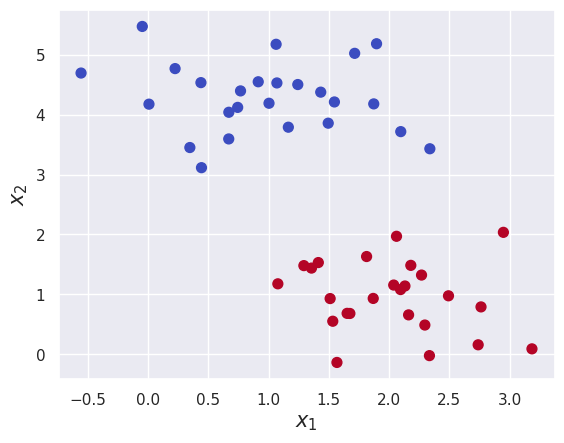

In [ ]:
plt.scatter(X[:,0],X[:,1], c=y, s=50, cmap='coolwarm')
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15);
#plt.savefig('decbaund.pdf', format='pdf', dpi=500, bbox_inches='tight')

Un clasificador discriminativo va a trazar una frontera entre los dos grupos. Sin embargo, ¿cómo debe ser esa frontera? Podemos trazar varias.

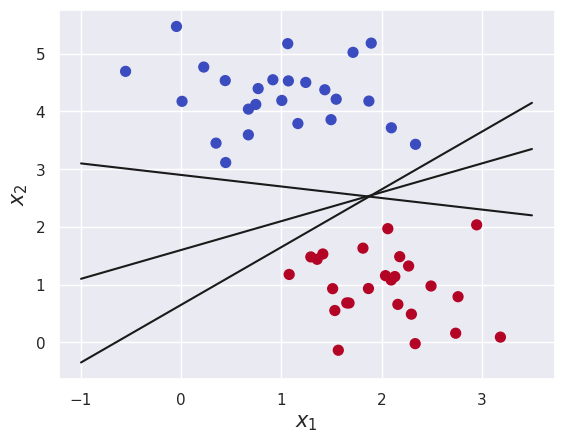

In [ ]:
xfit = np.linspace(-1,3.5)
plt.scatter(X[:,0],X[:,1], c=y, s=50, cmap='coolwarm')

for w, b in [(1,0.65), (0.5,1.6), (-0.2,2.9)]:
  plt.plot(xfit, w*xfit+b, '-k',)

#plt.xlim(-1,3.5);
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15);

¿Cuál es la más adecuada?
Las tres líneas discriminan perfectamente los dos grupos de datos. Sin embargo, en función de cuál seleccionemos, un nuevo dato se podrá clasificar de una forma diferente.

<a id='subsec_Margin'></a>
## Classification margin

Las máquinas de vector soporte (SVM) son una forma de abordar esto.

Lo que hace el método es no solo dibujar una línea, sino considerar una *región* en torno a la línea de un ancho determinado.

A continuación, se muestra un ejemplo de cómo podría verse esa región:

Debemos seleccionar una frontera que *maximice* el margen, la separación entre grupos.


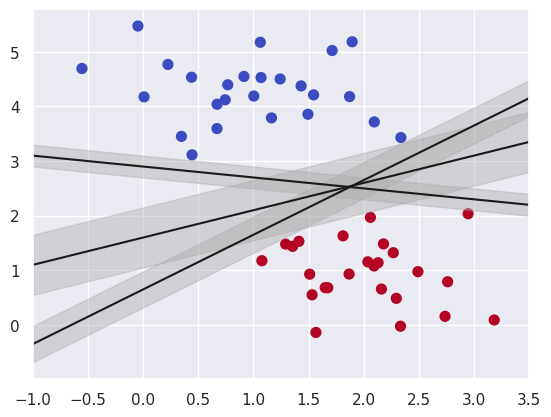

In [ ]:
xfit = np.linspace(-1,3.5) # 50 muestras por defecto
plt.scatter(X[:,0],X[:,1], c=y, s=50, cmap='coolwarm')

for m, b, d in [(1,0.65, 0.33), (0.5,1.6, 0.55), (-0.2,2.9, 0.2)]:
  yfit = m*xfit+b
  plt.plot(xfit, yfit, '-k')
  plt.fill_between(xfit, yfit-d, yfit+d, edgecolor='none', color='#AAAAAA', alpha=0.4)


plt.xlim(-1,3.5);
# plt.savefig('decbaund1.pdf', format='pdf', dpi=500, bbox_inches='tight')

La frontera que mayor margen tiene es la que separa mejor los dos grupos.

Esta es la idea detrás de las máquinas de vector soporte.
Podemos pensar un clasificador SVM como el ajuste de de la *calle* más ancha posible (representada por las franjas semitrasparentes y paralelas en torno a la línea que separa las clases.

Este es un problema que casi podríamos resolver a mano. Sin embargo, ¿cómo lo haríamos si el problema tiene más features de entrada?

El resultado exacto se obtiene resolviendo el problema de optimización que podríamos plantear.


# Decision function and predictions

En logistic regression usamos el vector $\boldsymbol{\theta}$, que incluía el parámetro bias $\theta_0$. Además, añadíamos la entrada $x_0=1$ a todas las instancias del dataset.
 En SVM vamos a usar una nomenclatura más conveniente que se ajuste al código que tenemos implementado:

- Vector de features: ${\boldsymbol{\theta}}$
- término de bias: $b$

El clasificador SVM lineal predice la clase de una nueva instancia ${\bf x}$ computando la *función de decisión*:

$$
  {\bf w}^\intercal {\bf x} +b = w_1 x_1 + \cdots + w_n x_n
$$

si el resultado es positivo, la clase estimada es la clase *positiva* (1), y, en caso contrario es la clase *negativa* (0).

$$
\hat{y} =
\begin{cases}
  0 &\mbox{si } {\bf w}^\intercal {\bf x} +b < 0 \\
  1 & \mbox{si } {\bf w}^\intercal {\bf x} +b \geq 0
\end{cases}
$$

La siguiente figura muetra el plano que representa la función de decisión si resolvemos nuestro problema de los dos blobs con el modelo SVM lineal. Podemos usar `LinearSVC()` o bien usar una instancia de `SVC`, *Support Vector Classifier*, con el `kernel='linear'`. Si el dataset es muy grande usaremos `LinearSVC()` que resulta más rápido. En nuestro caso, usamos dataset pequeños usamos esta segunda versión por sencillez:

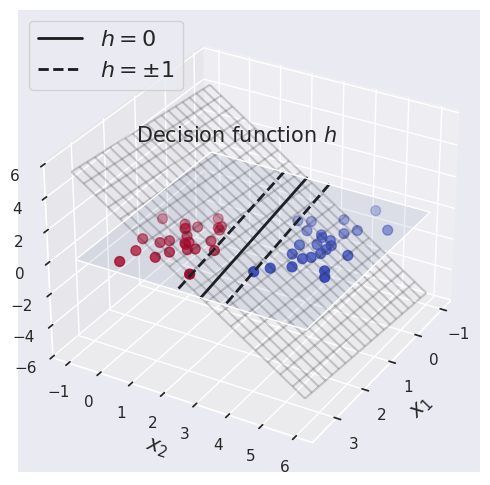

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC # "Support Vector Calssifier"

clf = SVC(kernel='linear')
clf.fit(X, y)

def plot_3D_decision_function(ax, w, b,  x1_lim=[-1, 3.5], x2_lim=[-1, 6]):
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.1, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    # función de decisión
    ax.plot_wireframe(x1, x2, df, alpha=0.2, color="k")
    plt.scatter(X[:,0],X[:,1], c=y, s=50, cmap='coolwarm')
    #ax.axis(x1_lim + x2_lim)
    ax.text(2, -0.5, 5.25, "Decision function $h$", fontsize=15)
    ax.set_xlabel(r"$x_1$", fontsize=15)
    ax.set_ylabel(r"$x_2$", fontsize=15)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=14)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
ax1.view_init(elev=30, azim=30)
plot_3D_decision_function(ax1, w=clf.coef_[0], b=clf.intercept_[0]);

La frontera de decisión es la línea se separación (linea continua en la figura) donde la función de decisión es igual a $0$; corresponde a la instersección entre los dos planos.

Más sencillo resulta visualizar este resultado en 2D:

Vamos a crear una función para dibujar la frontera de decisión. La función del modelo a dibujar se llama `clf.decision_function`

In [ ]:
plt.contour ?

In [ ]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 30),
                         np.linspace(ylim[0], ylim[1], 30))

    xy = np.vstack([xx.ravel(), yy.ravel()]).T

    P = clf.decision_function(xy).reshape(xx.shape)

    # Plot decision boundary and margins
    ax.contour(xx, yy, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


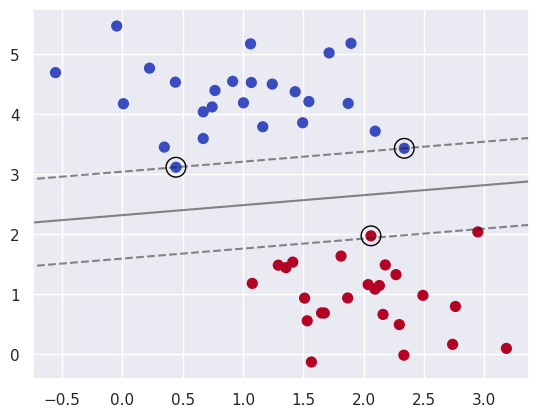

In [ ]:
plt.scatter(X[:,0],X[:,1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200,
            facecolors='none',
            edgecolor='black'
            )
plt.show()


Observe que las líneas punteadas tocan un par de puntos: estos puntos son las piezas fundamentales de este ajuste, y se conocen como ***vectores de soporte*** (dando al algoritmo su nombre).
En `scikit-learn`, estos se almacenan en el atributo `support_vectors_` del clasificador:

Usemos la funcionalidad `interact` de `IPython` para explorar cómo la distribución de puntos afecta los vectores de soporte y el ajuste discriminativo.

In [ ]:
SVC?

In [ ]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

def plot_svm(N=10):
    plt.clf()  # Clear current plot
    X, y = make_blobs(n_samples=250, centers=2,
                      random_state=0, cluster_std=0.70)
    X = X[:N]
    y = y[:N]
    # C=1 dafault value
    clf = SVC(C=1,kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    plt.show()  # Show the updated plot

interact(plot_svm, N=[10,30,100, 120, 160, 200, 250]);


interactive(children=(Dropdown(description='N', options=(10, 30, 100, 120, 160, 200, 250), value=10), Output()…

Las líneas punteadas representan donde la función de decisión es igual a $1$ o $-1$. Son líneas paralelas en torno a la frontera de decisión ($h=0$), y forman un margen alrededor.

Entrenar un clasificador lineal SVM significa encontrar los valores de ${\bf w}$ y de $b$ que hacen los márgenes tan anchos como sea posible, evitando instancias entre esos márgenes, (*hard margin*), o, limitándolos, (*soft margin*).

## Objetivo de entrenamiento

En el ejemplo que venimos estudiando con dos features hemos visualizado la función de decisión. La pendiente de la función de decisión es igual a la norma del vector de pesos $\|{\bf w}\|$.

Si dividimos la pendiente por $2$, los puntos donde la función de decisión vale $\pm 1$ estarán el doble de lejos de la frontera de descisión. Es decir, dividiendo la pendiente por 2, duplicamos el margen.
Esto lo podemos visualizar fácilmente en 2D, usando una feature $x_1$:

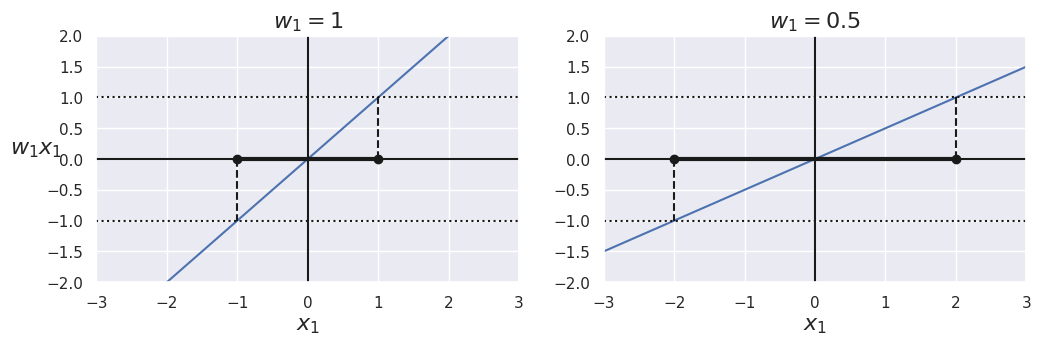

In [ ]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y) # función de decisión h = w*x1 + b
    plt.plot(x1_lim, [1, 1], "k:") # margen h=1
    plt.plot(x1_lim, [-1, -1], "k:") # margen h=-1
    plt.axhline(y=0, color='k') # eje horizontal
    plt.axvline(x=0, color='k') # eje vertical
    plt.plot([m, m], [0, 1], "k--") # si w=1, va de (m,0) -- (m,1)
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3) # 'margen'
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

plt.figure(figsize=(12, 3.2))
plt.subplot(121)
plot_2D_decision_function(1, 0)
plt.subplot(122)
plot_2D_decision_function(0.5, 0, ylabel=False)

Cuanto más pequeña se la pendiente, es decir el vector ${\bf w}$ más grande será el margen de separación de las clases.

Por tanto, querremos *minimizar* $\|{\bf w}\|$ para tener un margen grande.

Si también queremos evitar que haya instancias dentro del margen (*hard margin*), entonces necesitamos una función de decisión que haga $>1$ todas las instancias positivas, y, que haga $<-1$ para todas las negativas.

Si definimos $t^{(i)}$ de la siguiente forma:

$$
t^{(i)} =
\begin{cases}
  -1 &\mbox{si }\, y^{(i)} = 0 \\
  1 & \mbox{si }\, y^{(i)} = 1
\end{cases}
$$

entonces podemos expresar la restricción de la forma:$\hspace{3mm}$ $t^{(i)}\left({\bf w}^\intercal {\bf x}^{(i)} + b \right)\geq 1$ para todas las instancias

Por tanto, podemos expresar el objetivo del clasificador lineal (*hard margin* version) como el siguiente problema de optimización:

\begin{aligned}
& \underset{{\bf w},b}{\text{minimize}}
& & \frac{1}{2}{\bf w}^\intercal{\bf w} & \\
& \text{subject to}
& & t^{(i)}\left({\bf w}^\intercal {\bf x}^{(i)} + b \right)\geq 1 & \forall i=1,2,\cdots,m
\end{aligned}



No minimizamos directamente $\|{\bf w}\|$ que es una función no continua en ${\bf w}=0$

## Soft margin


Hemos impuesto que las instancias estén fuera de la *calle*. Existen dos problemas con clasificar *hard*:

1. Sólo funciona bien si los datos son linealmente separables
2. Resulta sensible a *outliers* y no *generaliza* bien.

Los márgenes cambian si introducimos nuevas instancias. La consecuencia es similar a *overfitting* que hemos visto en los problemas de regresión.

Para evitarlo, se busca flexibilizar el modelo. El objetivo consiste en encontrar un balance entre tener una *calle* lo más ancha posible y lilmitar las instancias que caen dentro de los márgenes (*margin violations*). Las instancias pordrían situarse dentro de la *calle* e incluso *en el lado contrario*, donde están las instancias clasificadas diferente.

Para conseguir una clasificación con margen *soft* debemos cambiar el objetivo introduciendo una variable que relaje la condición impuesta de no permitir instancias dentro, $\zeta^{(i)}\geq 0$ para cada instancia: $\zeta^{(i)}$ mide cuanto se permite que la instancia $i$ *viole* el margen.

Ahora tenemos dos objetivos contrapuestos:

* hacer $\zeta^{(i)}$ lo más pequeña posible para no permitir violaciones de márgen, y
* hacer $\frac{1}{2}{\bf w}^\intercal{\bf w}\,$ lo más pequeño posible para para *agrandar* el márgen.

Para modular estos $2$ objetivos introducimos el hiperparámetro $C$ y el problema de optimización del clasificador es:

\begin{aligned}
& \underset{{\bf w},b,\zeta}{\text{minimize}}
& & \frac{1}{2}{\bf w}^\intercal{\bf w}\, + C \sum_{i=1}^m \zeta^{(i)} &  \\
& \text{subject to}
& & t^{(i)}\left({\bf w}^\intercal {\bf x}^{(i)} + b \right)\geq 1-\zeta^{(i)} & \zeta^{(i)}\geq 0,\, \forall i=1,2,\cdots,m
\end{aligned}

que se trata de un problema de optimización convexo con restricción lineal. La resolución de este problema queda fuera de nuestro objetivo; usaremos `sklearn` que implementa varios solvers para estos problemas.

El hiperparámetro $C$ es uno de los que podemos ajustar. Si establecemos un valor bajo ($\approx 0$) tenemos un modelo que permitirá violaciones de margen. Con valores altos tendremos un modelo *hard* que no permitirá que haya instancias en el margen de decisión. Vamos a mira el valor por defecto y lo subiremos para tener un clasificador *hard*.


In [ ]:
SVC?

Por defecto $C=1$; vamos a subirlo a $100$.

In [ ]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

def plot_svm(N=10):
    fig, ax = plt.subplots()  # Create a new figure and axis
    X, y = make_blobs(n_samples=250, centers=2,
                      random_state=0, cluster_std=0.70)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear', C=100)
    clf.fit(X, y)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(clf, ax)
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    plt.show()  # Show the updated plot

interact(plot_svm, N=[10,30,100, 120, 160, 200, 250]);


interactive(children=(Dropdown(description='N', options=(10, 30, 100, 120, 160, 200, 250), value=10), Output()…

Vemos como reduce el márgen para que no haya violaciones de márgen conforme subimos la cantidad de instancias.

# Clasificación SVM no-lineal

El datasetde los ejemplos que acabamos de ver tiene instancias que son linealmente separables. Sin embargo, podemos tener datasets con instancias que no lo son.

Veamos el siguiente ejemplo de clasificación:

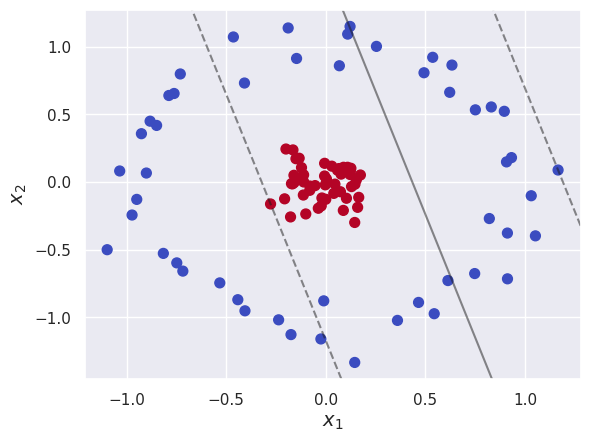

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1, random_state=0)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(clf);
plt.xlabel(r'$x_1$', fontsize=14)
plt.ylabel(r'$x_2$', fontsize=14);

Claramente, ninguna discriminación lineal separará jamás estos datos.

En general, existen dos formas de abordar estos problemas:

1. Añadir features polinómicas. Habitualmente usamos kernels polinómicos de mayor grado (combinación lineal de funciones base polinómicas), como ya vimos en *regresión logística*. El inconveniente es que al subir el grado del polinomio terminamos creando gran cantidad de features y no podemos usarlo con datasets complejos.

2. Añadir features usando *similarity functions*, la más usada es la Gaussian *Radial Basis Function* (RBF). En este caso veremos que también podemos tener una *explosión* de features.


Afortunadamente, en los dos casos se aplica la técnica del ***kernel trick***.
El [kernel trick](https://en.wikipedia.org/wiki/Kernel_method) obtiene los mismos resultados que si incrementamos mucho la cantidad de features (incluso para polinomios de grado muy alto), sin tener que añadirlos realmente.

## Kernel trick

La idea tras el kernel trick es, partiendo de un dataset con instancias no linealmente separables transformar esas instancias a una dimensión superior donde sí son separables.

Podemos visualizar la técnica del kernel trick en el dataset anterior. Viendo la disposición circular de las dos clases, a las features $x_1$ y $x_2$ añadimos una tercera $x_3$ que varíe con el radio desde el punto $(0,0)$, y pasamos de un espacio de dimensión 2D a otro 3D:

In [ ]:
x_3 = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

Si ahora dibujamos con nuestros datos podemos ver el efecto producido:

In [ ]:
from mpl_toolkits import mplot3d

def plot_3D(elev=21, azim=-13):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], x_3, c=y, s=50, cmap='coolwarm')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel(r'$x_1$', fontsize=15)
    ax.set_ylabel(r'$x_2$', fontsize=15)
    ax.set_zlabel(r'$x_3$', fontsize=15)
    plt.show()

interact(plot_3D, elev=(-90, 90), azim=(-180, 180));


interactive(children=(IntSlider(value=21, description='elev', max=90, min=-90), IntSlider(value=-13, descripti…

Podemos ver que con esta dimensión adicional, los datos se vuelven linealmente separables.

Por ejemplo, podemos usar un kernel polinómico de grado 2 para realizar la clasificación:

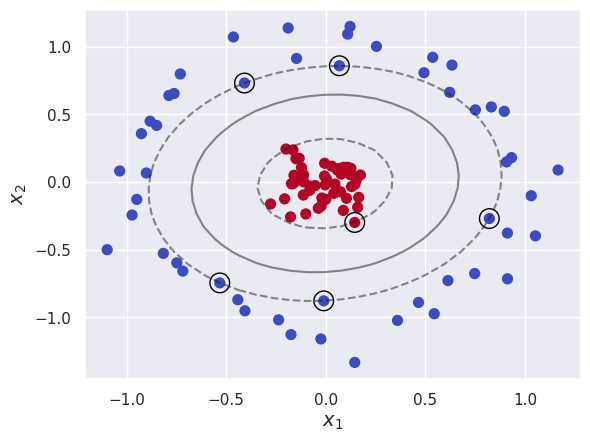

In [ ]:
clf = SVC(kernel='poly', degree=2, coef0=1, C=5)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200,
            facecolors='none',
            edgecolor='black'
            );

plt.xlabel(r'$x_1$', fontsize=14)
plt.ylabel(r'$x_2$', fontsize=14);

El hiperparámetro `coef0` (sólo para `kernel='poly'`) controla cuánto está influenciado el modelo por polinomios de grado alto. Podemos probar con un grado 10, y deberíamos subir el valor de `coef0`, por ejemplo, a 20 para obtener un valor similar a este.

Recordemos que podemos realizar una búsqueda de los hiperparámetros usando `GridSearchCV`.

## Similarity functions

Las funciones de similaridad mide cuánto se ajusta cada instancia a un punto de referencia.

Por ejemplo, la siguiente figura representa un dataset de 9 puntos situados en una recta (feature $x_1$). Por lo tanto no son linealmente separables. Vamos a añadir dos puntos de referencia (*landmarks*), uno en $x_1=-2$ y otro en $x_1=1$.

Las funciones de similaridad son Gaussian ***Radial Basis Functions*** (RBF):

$$
\phi_{\gamma}({\bf x},l\,)= \exp \left( -\gamma \|{\bf x}-l\|^2 \right)
$$
con $\gamma=0.3$.

Estas funciones de similaridad tienen forma *acampanada*, tomando valor 0 en puntos distantes del landmark, y valor 1 justo en el landmark.

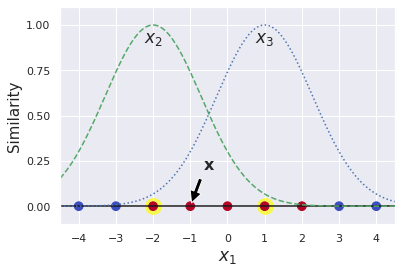

In [ ]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=250, alpha=0.65, c="yellow")
plt.scatter(X1D, np.zeros(9), c=yk, s=75, cmap='coolwarm')
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=17)
plt.ylabel(r"Similarity", fontsize=15)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=17)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=17)
plt.axis([-4.5, 4.5, -0.1, 1.1]);


En la figura hemos situado 2 landmarks, uno en $x_1=-2$ y otro en $x_1=1$.

Usando las funciones de similaridad con media en los dos landmarks calculamos las nuevas features.
Por ejemplo, para la instancia $x_1=-1$ las funciones de similaridad valen:

In [ ]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


que corresponden a las dos nuevas features $x_2$ y $x_3$. En la siguiente figura representamos el nuevo dataset transformado (eliminado la feature original):

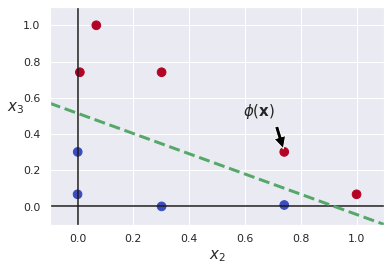

In [ ]:
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
#plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
#plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.scatter(XK[:,0], XK[:,1], c=yk, s=75, cmap='coolwarm')
plt.xlabel(r"$x_2$", fontsize=15)
plt.ylabel(r"$x_3$  ", fontsize=15, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=15,
            )
# creamos una frontera lineal arbitraria:
plt.plot([-0.1, 1.1], [0.57, -0.1], "g--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1]);

Resulta difícil decidir dónde debemos situar los landmarks. La forma de proceder en situar un landmark en todas las instancias del dataset.

De esta forma creamos bastantes dimensiones y aumentamos la posibilidad de que el dates transformado sea linealmente separable. Si eliminamos las features originales, después de la transformación nos quedará un dataset con $m$ instancias y cada una con $m$ features. Si el training set es muy grande podemos terminar con una cantidad también muy grande de features.

## Gaussian RBF kernel

Tanto el método de añadir features polinómicas como el método de funciones/features de similaridad pueden estenderse y aplicarse a otros algoritmos de aprendizaje máquina. Sin embargo, pueden resultar computacionalmente costosos.

El kernel trick va a posibilitar obtener resultados comoparables a si hubiéramos añadido muchas features de similaridad. Vamos a probar la clase `SVC` con Gaussian RBF kernel.

Vamos a clasificar el `moons` dataset: es un dataset sencillo de clasificación binaria, donde los datos forman dos semicírculos entrelazados. Lo generamos usando `make_moons()` (similar a como hemos hecho con `make_blobs` y `make_circles`).

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(
    n_samples=100,
    noise=0.15,
    random_state=42
    )

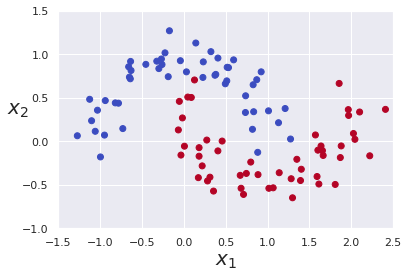

In [ ]:
def plot_dataset(X, y, axes):
    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [ ]:
clf = Pipeline([
                ('scaler', StandardScaler()),
                ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])

In [ ]:
clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

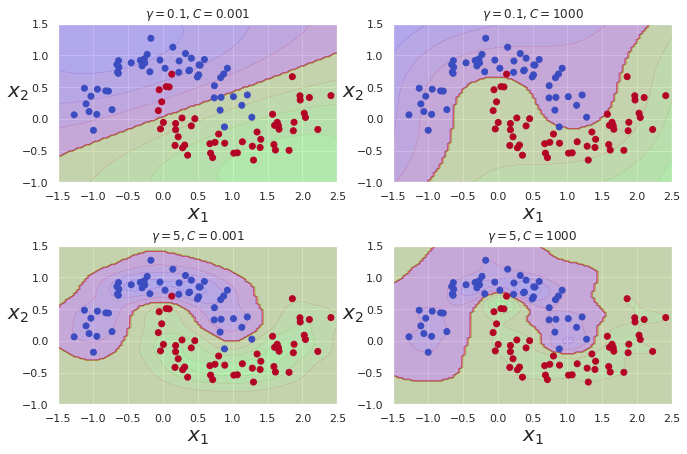

In [ ]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    clf.fit(X, y)
    svm_clfs.append(clf)

plt.figure(figsize=(11, 7))
plt.subplots_adjust(hspace=0.4)
for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=12)

Comprobamos que incrementar $\gamma$ hace la función de similaridad más estrecha, y, como consecuencia el efecto de cada instancia sobre los demás es menor. Cada instancia afecta a la frontera de separación en su zona lo que hace la línea más irregular. Si $\gamma$ es pequeño las instancias tienen efecto a más distancia y la frontera se hace más suave.

Por tanto, $\gamma $ actúa como un hiperparámetro de regularización. Si tenemos *overfitting* debemos reducirlo, y si el modelo muestra *underfitting* debemos aumentarlo. Similar al hiperparámetro `C=`.

# Regresión con SVM

SVM es potente se puede aplicar a muchos problemas de clasificación, pero, además, es muy versatil. SVM soporta regresion lineal y no lineal.

La idea consiste en invertir el objetivo del clasificador. En lugar de intentar conseguir la *calle* más ancha y con el menor número de violaciones, el regresor intenta introducir en la *calle* tantas instancias como sea posible, y, limitar el número de violaciones (instancias fuera del margen).

El hiperparámetro $\epsilon$ controla la anchura de la *calle*.

## Ejercicio:

Utilizar la clase *Epsilon Support Vector Regression*, `SVR()` para construir y representar un regresor para los datos generados siguientes:

In [ ]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

Obtenga resultados para varios valores de $\epsilon$ comenzando por el valor por defecto.

Compruebe también el efecto de parámetro `C=` con valores de 100 y de 0.01.

*A partir de aquí deben realizar:*

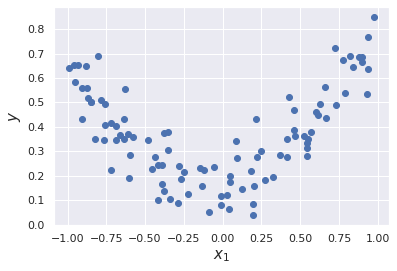

In [ ]:
plt.scatter(X, y);
#plt.axis([-1, 1, 0, 1])
plt.xlabel(r'$x_1$', fontsize='15')
plt.ylabel(r'$y$', fontsize='15');

In [ ]:
from sklearn.svm import SVR
reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="auto")
reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper center", fontsize=18)
    plt.axis(axes)

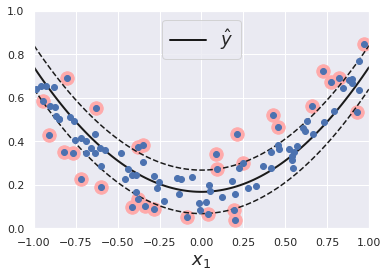

In [ ]:
plot_svm_regression(reg, X, y, [-1, 1, 0, 1])